In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.signal import resample

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

/Users/apple/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read data

In [2]:
df = pd.read_excel('sheet.xlsm', 'dados')

FileNotFoundError: [Errno 2] No such file or directory: 'sheet.xlsm'

In [ ]:
df.head()

In [27]:
df_test = pd.read_excel('sheet.xlsm', 'teste')

In [28]:
df_test.head()

,Tempo,Corrente ideal para 43378 A,Corrente real para 43378 A
0,0.000000,0.000000,-1.823944e-51
1,0.000083,-2.212294,-2.212294e+00
2,0.000167,-4.031354,-4.031354e+00
3,0.000250,-5.457833,-5.457833e+00
4,0.000333,-6.492759,-6.492759e+00


### Model

You can set smaller batch_size and bigger epochs to achieve better loss, but train slower.

In [354]:
numberofsinewavesonthemodel=9
samplingrateofthemathematicalmodel=200

caseswindow = [10*i for i in range(1,6)] # from 10 to 50
casessampling = [200]

Sampling: 20, window: 10
MSE: 35.179066


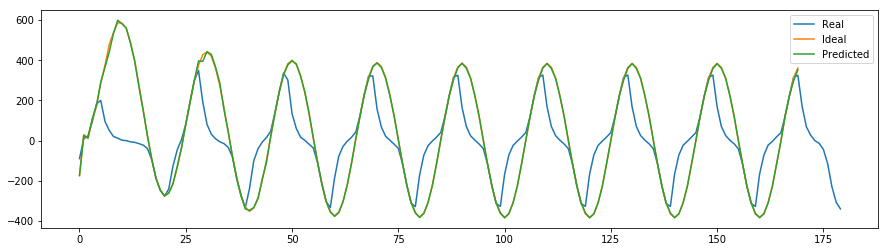

Sampling: 20, window: 20
MSE: 1.677334


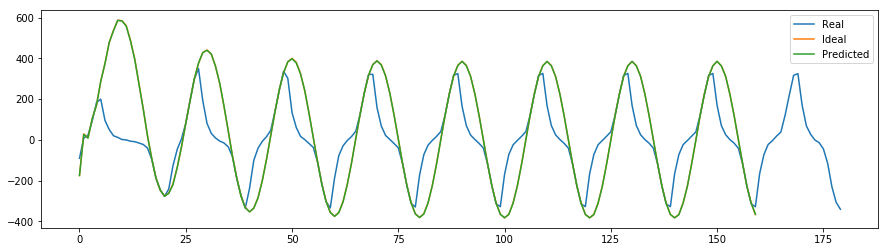

Sampling: 20, window: 30
MSE: 1.008992


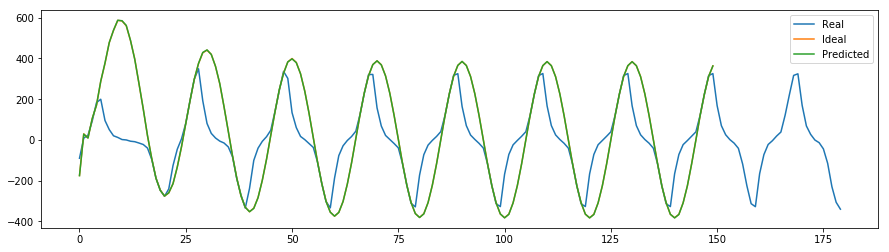

Sampling: 20, window: 40
MSE: 2.165550


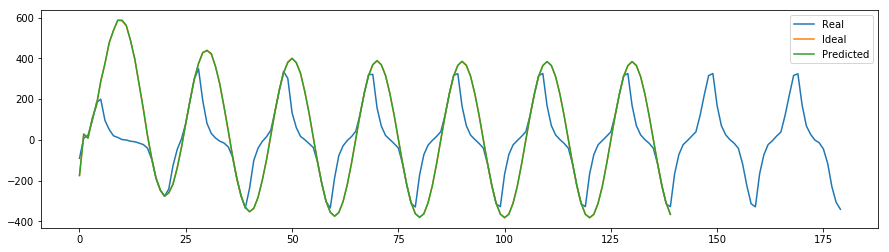

Sampling: 20, window: 50
MSE: 1.784695


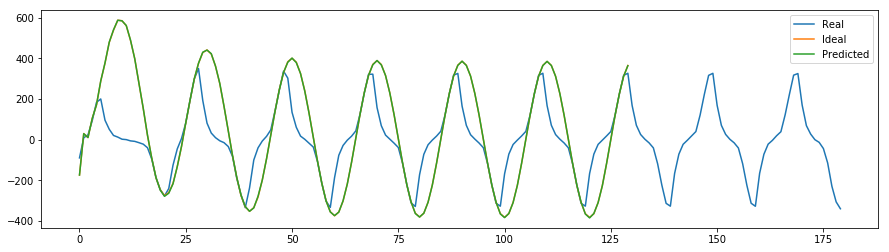

Sampling: 40, window: 10
MSE: 204.008273


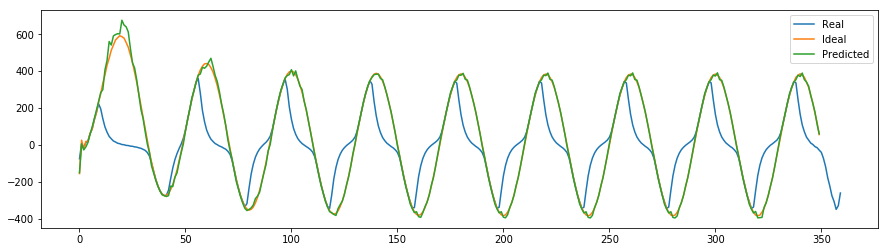

Sampling: 40, window: 20
MSE: 65.375476


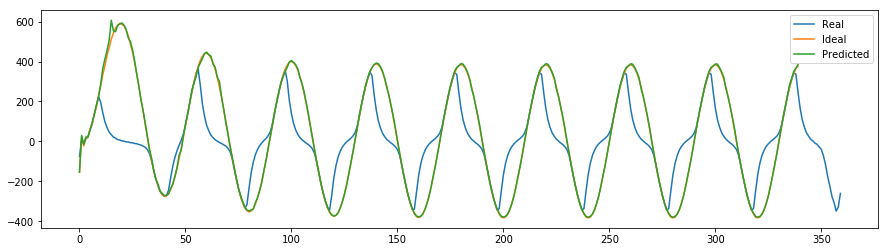

Sampling: 40, window: 30
MSE: 2.566291


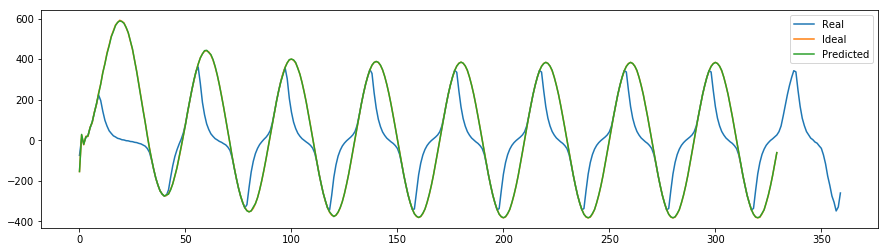

Sampling: 40, window: 40
MSE: 1.815648


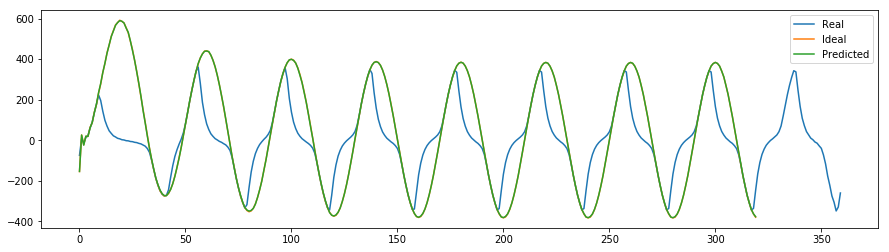

Sampling: 40, window: 50
MSE: 1.394733


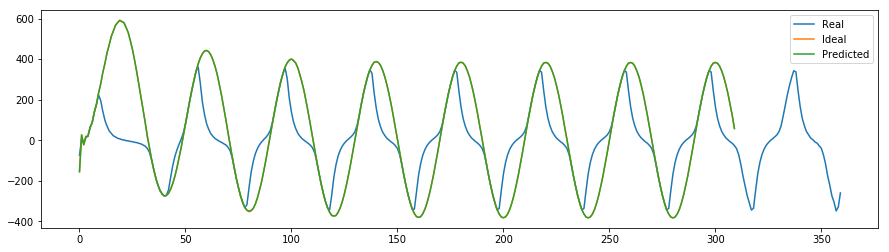

Sampling: 50, window: 10
MSE: 298.092718


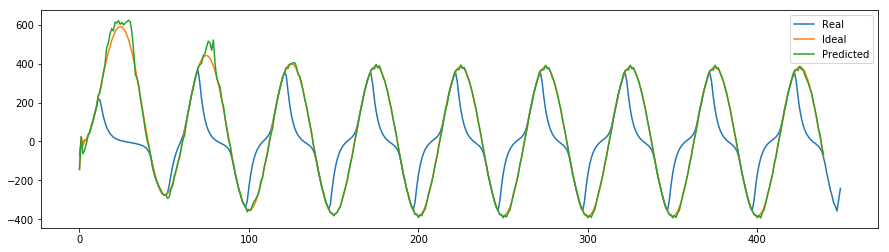

Sampling: 50, window: 20
MSE: 67.435877


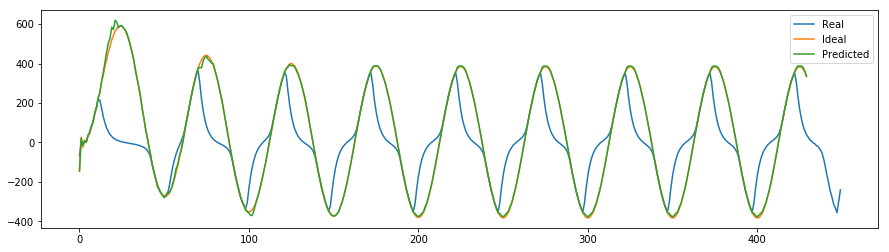

Sampling: 50, window: 30
MSE: 11.016152


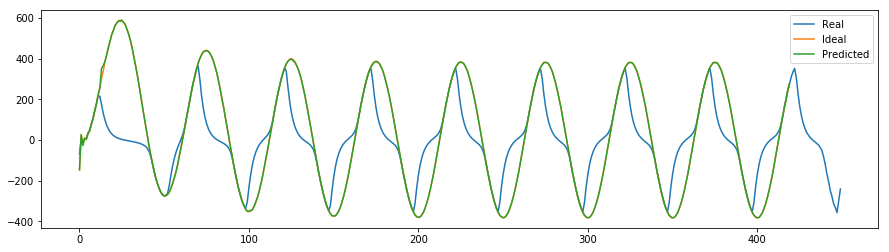

Sampling: 50, window: 40
MSE: 1.893302


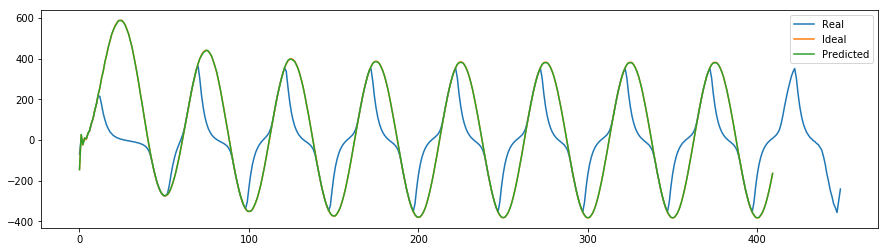

Sampling: 50, window: 50
MSE: 1.179160


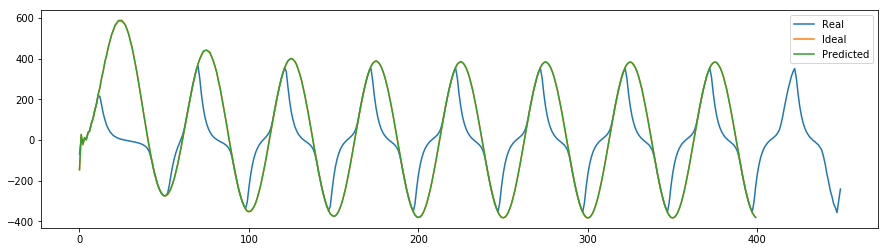

In [544]:
for sampling in casessampling:
    for window in caseswindow:
        totalsampling = numberofsinewavesonthemodel * samplingrateofthemathematicalmodel
        linestepfortheexcelsheet = samplingrateofthemathematicalmodel / sampling
                
        train_data = resample(df.values[:, 1:], numberofsinewavesonthemodel*sampling)
        test_data = resample(df_test.values[:, 1:], numberofsinewavesonthemodel*sampling)
        
        # Sliding window over train_data
        X = []
        y = []
        for i in range(train_data.shape[1]):
            if (i+1)%2 != 0: # y
                y.append(train_data[:, i][:sampling*numberofsinewavesonthemodel-window])
            else: # X
                m = []
                for j in range(window, len(train_data[:, i])):
                    m.append(train_data[:, i][j-window:j])
                X.append(m)
                
        X = np.array(X)
        y = np.array(y)
        X = X.reshape(-1, X.shape[2])
        y = y.reshape(-1, 1)
        
        # Sliding window over test_data
        X_test = []
        y_test = []
        y_test.append(test_data[:, 0][:sampling*numberofsinewavesonthemodel-window])
        m = []
        for j in range(window, len(test_data[:, 1])):
            m.append(test_data[:, 1][j-window:j])
        X_test.append(m)
        
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        X_test = X_test.reshape(-1, X_test.shape[2])
        y_test = y_test.reshape(-1, 1)
        
        # NN model
        model = Sequential()
        model.add(Dense(200, activation='selu', kernel_initializer='lecun_normal', input_shape=[X.shape[1]]))
        model.add(Dense(100, activation='selu', kernel_initializer='lecun_normal'))
        model.add(Dense(50, activation='selu', kernel_initializer='lecun_normal'))
        model.add(Dense(25, activation='selu', kernel_initializer='lecun_normal'))
        model.add(Dense(1))
        model.compile(optimizer=Adam(0.0001), loss='mse')
        
        def reg_lr(n):
            return 0.0001*0.96**(n/4)
        lr = keras.callbacks.LearningRateScheduler(reg_lr)
        
        model.fit(X, y, validation_data=[X_test, y_test], batch_size=128, epochs=200, callbacks=[lr], verbose=0)
        
        print('Sampling: %d, window: %d' % (sampling, window))
        print('MSE: %f' % (model.evaluate(X_test, y_test, verbose=0)))
        
        pr = model.predict(X_test)
        
        # Plots
        plt.figure(figsize=(15, 4))
        plt.plot(test_data[:, 1], label='Real')
        plt.plot(y_test.reshape(-1), label='Ideal')
        plt.plot(pr.reshape(-1), label='Predicted')
        plt.legend()
        plt.show();